# NCG613 - Group 2 - Group Project 1
## An Exploratory Analysis of Crime in London, United Kingdom
##### Authors: Mark Walter Alfred, Saad Siddiqui, Ruineng Huang and Fernando Nicolas Szeliga Cabezuelo

### Introduction

This project is an exploratory analysis of crime in London, United Kingdom (UK). Specifically, the analysis is focused on the potential correlation of crime with immigration and professional occupation at the Lower Layer Super Output Area (LSOA) level. The data obtained for the analysis are from the years 2011 and 2021.

The research questions of this analysis are the following:

1. Is there an association between crime levels and non-UK population rates in London LSOAs?
2. Is there an association between crime levels and professional occupation rates in London LSOAs?

The main motivations for carrying out this analysis are the following:

- The UK has significant free and open data available, reducing data availability limitations.

- LSOA level analysis allows for the visualisation of the specific areas with a certain trend or correlation.

- The data is readily available from official sources, which ensures a level of accuracy and reliability.

- The data is denominated as "hard data", meaning they are quantitative and can easily be statistically analysed.

- Interest in exploring the impact of the claimed high influx of immigrants on crime rates. This is particularly compelling following the favourable voting for Brexit in 2016.

- Interest in examining differences in crime rates pre-COVID-19 pandemic (2011) and during the COVID-19 pandemic (2021).

The data for this analysis is obtained from the following sources:

- [Metropolitan Police](https://data.london.gov.uk/dataset/recorded_crime_summary): the historical crime dataset ("MPS LSOA Level Crime (Historical)") provides crime data from April 2010 to January 2022 with the monthly number of crimes by LSOA and by crime type. However, this source does not contain crime data on the City of London because this data is managed by the City of London Police, a different territorial police force. 

- [Data.Police.UK](https://data.police.uk/data/archive/): a site for open data about crime and policing in England, Wales and Northern Ireland. This site has monthly crime data available for the City of London at the LSOA level only for 2021. This data was utilised to calculate a weighted estimation of the crime numbers in the City of London LSOAs for 2011.

- [Census Information Scheme - Demography and Migration](https://data.london.gov.uk/dataset/2021-census-lsoa-demography-and-migration): provides several UK demographic datasets from the 2011 and 2021 census. The migration data is catered in the "Country of Birth" file, which categorises the inhabitants in each LSOA by country of birth.

- [Census Information Scheme - Labour Market](https://data.london.gov.uk/dataset/2021-census-lsoa-labour-market): provides numerous UK labour market datasets from the 2011 and 2021 census. The professional occupation dataset used in the analysis is available in the "Occupation" file, which groups the LSOA inhabitants that are 16 years of age or over in employment among these categories:

    1. Managers, directors and senior officials.	

    2. Professional occupations.

    3. Associate, professional and technical occupations.

    4. Administrative and secretarial occupations.

    5. Skilled trades occupations.

    6. Caring, leisure and other service occupations.

    7. Sales and customer service occupations.

    8. Process, plant and machine operatives.
    
    9. Elementary occupations.

- [Office for National Statistics](https://geoportal.statistics.gov.uk/datasets/31dac98df61a4312991646842b147e2f_0/explore?showTable=true): provides free and open access to geographic products among other useful information. A shape file with the UK 2021 Output Areas (OAC) boundaries and their corresponding LSOA code is downloadable from this website. The study area encloses 4,994 LSOA boundaries. It is worth noting that there are LSOA boundary differences between 2011 and 2021, however, the LSOA codes referred to in the data described above are in line with the 2021 boundaries. 


### Methodology

The data wrangling completed before the data analysis is developed in the code below. The data wrangling included the following processes:

- **Crime**: the crime data from the Metropolitan Police was reduced to the total number of crimes each year (2011 and 2021) by LSOA. Similarly, the monthly number of crimes by LSOA in the City of London was extracted from the website "Data.Police.UK", which involved the processing of twelve Excel files of data, to calculate the total number of crimes in 2021. The 2011 crime numbers for the City of London LSOAs were estimated by calculating a weighted estimation from the 2021 figures. Finally, the crime rates for 2011 and 2021 were calculated in terms of crime numbers by 1000 people in the respective LSOA. For consistency purposes, the crime rate was calculated using the LSOA total population under the "all usual residents" column in the "country of birth" dataset.

- **Non-UK population**: the population numbers by country of birth provided by the Census Information Scheme - Demography and Migration were grouped into two categories by LSOA: people born in the UK and people not born in the UK. A rate for both of these groups was calculated by dividing by the LSOA total population.

- **Occupation**: the data extracted from the Census Information Scheme - Labour Market was re-grouped in the following three categories:

    - *White-Collar Group*: occupations requiring work in an office environment. Classes 1, 2 and 3 from the dataset were grouped into this category.

    - *Blue-Collar Group*: occupations requiring hard manual labour. Classes 4, 5 and 8 were grouped into this category.

    - *Elementary Group*: occupations with low entry requirements. Classes 6, 7 and 9 were grouped into this category.

    Occupation rates were calculated by dividing each group by the LSOA total number of people aged 16 or over in employment provided in the dataset.

- **Data merging**: the processed data was merged using an outer join to retain LSOAs in the data frame when data was not available. This combined dataset was named "crime_final".

- **2021 LSOA Boundaries**: the boundaries geometry in the dataset were merged or "dissolved" by LSOA code. 

- **Joining geometry with data**: "crime_final" was merged to the LSOA boundaries by LSOA code, reducing the data frame to only the LSOAs located in London (4,994 LSOAs). This data frame was split in two, one for each year in this analysis.

In [1]:
import geopandas as geop
import pandas as pd
import numpy as np
import warnings
import seaborn
import matplotlib.pyplot as plt
import mapclassify
import plotly.express as px


In [2]:
# Reading crimes csv file

crime_hist = pd.read_csv('MPS LSOA Level Crime (Historical).csv')

In [3]:
# New data set with 2011 colums and new variable with sum calculation by row. 

crime_2011 = crime_hist[crime_hist.columns[crime_hist.columns.str.startswith(('2011'))]]
crime_2011_totals = crime_2011.sum(axis=1)

In [4]:
# New data set with 2021 colums and new variable with sum calculation by LSOA (row). 

crime_2021 = crime_hist[crime_hist.columns[crime_hist.columns.str.startswith(('2021'))]]
crime_2021_totals = crime_2021.sum(axis=1)

In [5]:
# Copy of crime data and merging of 2011 and 2021 totals by row

crime_cases = crime_hist
crime_cases ['2011 Crime Cases'] = crime_2011_totals
crime_cases ['2021 Crime Cases'] = crime_2021_totals

In [6]:
# Selection of column

crime_cases = crime_cases[['LSOA Code', 'LSOA Name', '2011 Crime Cases', '2021 Crime Cases']]

In [7]:
# Group by and summary of the dataset, grouping by LSOA Code and Name and them summary of totals by LSOA for 2011 and 2021

crime = crime_cases.groupby(['LSOA Code','LSOA Name']).agg(
    LSOA_Crime2011 =('2011 Crime Cases', 'sum'),
    LSOA_Crime2021 =('2021 Crime Cases', 'sum')
)

In [8]:
# Read in population by place of birth data 2011 and selection of relevant columns

POB_2011 = pd.read_excel('Country of birth.xlsx', sheet_name= '2011')
POB_2011 = POB_2011 [['LSOA code', 'All Usual residents','United Kingdom']]
POB_2011['Non UK Percentage']= 1-(POB_2011['United Kingdom']/POB_2011['All Usual residents'])

POB_2011.drop(columns='United Kingdom', inplace=True)
#POB_2011 = POB_2011 [['LSOA code', 'All Usual residents', 'Non UK Percentage']]
POB_2011 = POB_2011.rename(columns={'LSOA code': 'LSOA Code'})

In [9]:
# Read in population by place of birth data 2021 and selection of relevant columns

POB_2021 = pd.read_excel('Country of birth.xlsx', sheet_name= '2021')
POB_2021 = POB_2021 [['LSOA code', 'All Usual residents','United Kingdom']]
POB_2021['Non UK Percentage']= 1-(POB_2021['United Kingdom']/POB_2021['All Usual residents'])
POB_2021.drop(columns='United Kingdom' ,inplace=True)

POB_2021 = POB_2021.rename(columns={'LSOA code': 'LSOA Code'})

In [11]:
# Outer join with 2011 population

crime = crime.merge(POB_2011, on='LSOA Code', how='outer')

In [12]:
# Change of column name

crime = crime.rename(columns={'All Usual residents': '2011 Population'})

In [13]:
# Outer join with 2021 population

crime = crime.merge(POB_2021, on='LSOA Code', how='outer')

In [14]:
# Change of column name

crime = crime.rename(columns={'All Usual residents': '2021 Population'})
crime=crime.rename(columns={'Non UK Percentage_x': '2011 Non UK Percentage'})
crime=crime.rename(columns={'Non UK Percentage_y': '2021 Non UK Percentage'})

In [15]:
# Crime copy for final dataset
crime_final = crime.copy()

In [16]:
# Calculation of 2011 crime rate by 1000 people

crime_final ['2011 Crime/1000 people'] = crime_final ['LSOA_Crime2011']/ (crime_final['2011 Population']/1000)

In [17]:
# Calculation of 2021 crime rate by 1000 people

crime_final ['2021 Crime/1000 people'] = crime_final ['LSOA_Crime2021']/ (crime_final['2021 Population']/1000)

In [18]:
# Reading occupation csv file

# Read multiple sheets
sheet_names = ['2011', '2021', 'change 2011-2021']  # List of sheet names
df_dict = pd.read_excel('occupation.xlsx', sheet_name=sheet_names)

# Access each DataFrame by sheet name
df_2011 = df_dict['2011']
df_2021 = df_dict['2021']
df_change = df_dict['change 2011-2021']


In [19]:
# Column rename for 2011

df_2011.rename(columns={'All usual residents aged 16-74 in employment':'Total Workforce'}, inplace=True)

In [20]:
# Column rename for 2021

df_2021.rename(columns={'All usual residents aged 16 and over in employment':'Total Workforce'}, inplace=True)

In [21]:
# Categorising data in groups

column_categories = {
    'White Collar': ['1. Managers, directors and senior officials', '2. Professional occupations', '3. Associate professional and technical occupations'],
    'Blue Collar': ['4. Adminis-trative and secretarial occupations', '5. Skilled trades occupations', '8. Process, plant and machine operatives'],
    'Elementary': ['6. Caring, leisure and other service occupations', '7. Sales and customer service occupations', '9. Elementary occupations']
}


In [22]:
# 2011 data aggreated in 3 groups, update the proportion of each group

df_2011['White Collar Sum'] = df_2011[column_categories['White Collar']].sum(axis=1)
df_2011['White Collar Prop'] = df_2011['White Collar Sum'] / df_2011['Total Workforce']

df_2011['Blue Collar Sum'] = df_2011[column_categories['Blue Collar']].sum(axis=1)
df_2011['Blue Collar Prop'] = df_2011['Blue Collar Sum'] / df_2011['Total Workforce']

df_2011['Elementary Sum'] = df_2011[column_categories['Elementary']].sum(axis=1)
df_2011['Elementary Prop'] = df_2011['Elementary Sum'] / df_2011['Total Workforce']

df_2011 = df_2011.iloc[:, np.r_[0:3, -6:0]]

In [23]:
# 2021 data aggreated in 3 groups, update the proportion of each group

df_2021['White Collar Sum'] = df_2021[column_categories['White Collar']].sum(axis=1)
df_2021['White Collar Prop'] = df_2021['White Collar Sum'] / df_2021['Total Workforce']

df_2021['Blue Collar Sum'] = df_2021[column_categories['Blue Collar']].sum(axis=1)
df_2021['Blue Collar Prop'] = df_2021['Blue Collar Sum'] / df_2021['Total Workforce']

df_2021['Elementary Sum'] = df_2021[column_categories['Elementary']].sum(axis=1)
df_2021['Elementary Prop'] = df_2021['Elementary Sum'] / df_2021['Total Workforce']

df_2021 = df_2021.iloc[:, np.r_[2, -6:0]]

In [24]:
# 2011 data left joined with 2021 by LSOA code

merged_df = pd.merge(df_2011, df_2021, on='LSOA code', suffixes = (' 2011', ' 2021'), how='left')
merged_df.rename(columns={'LSOA code': 'LSOA Code'}, inplace = True)
merged_df.drop(columns=['local authority code','local authority name'], inplace=True)

In [25]:
# Some simple statistics for each group

print("The mean for each group: ")
print(merged_df.iloc[:,3:].mean())
print()
print("The standard deviation for each group: ")
print(merged_df.iloc[:,3:].std())
print()
print("The five numbers for each group: ")
print(merged_df.iloc[:,3:].quantile([0, 0.25, 0.5, 0.75, 1]))

The mean for each group: 
Blue Collar Sum 2011      197.894473
Blue Collar Prop 2011       0.253519
Elementary Sum 2011       199.692431
Elementary Prop 2011        0.258523
White Collar Sum 2021     485.943933
White Collar Prop 2021      0.550012
Blue Collar Sum 2021      183.773728
Blue Collar Prop 2021       0.213815
Elementary Sum 2021       203.400080
Elementary Prop 2021        0.236173
dtype: float64

The standard deviation for each group: 
Blue Collar Sum 2011       68.159236
Blue Collar Prop 2011       0.080192
Elementary Sum 2011        81.144250
Elementary Prop 2011        0.102680
White Collar Sum 2021     194.709248
White Collar Prop 2021      0.159419
Blue Collar Sum 2021       68.026368
Blue Collar Prop 2021       0.074444
Elementary Sum 2021        90.024265
Elementary Prop 2021        0.098754
dtype: float64

The five numbers for each group: 
      Blue Collar Sum 2011  Blue Collar Prop 2011  Elementary Sum 2011  \
0.00                   0.0               0.054945     

In [26]:
crime_final = crime_final.merge(merged_df, on = 'LSOA Code', how='outer')

In [27]:
# Read the crime data of 2021 for City of London
crime_col2021 = pd.read_csv('2021-city-of-london-street.csv')

In [28]:
# Select rows of LSOA codes that have NaN values in the Final crime data

na_lsoa = ['E01000001', 'E01000002', 'E01000003', 'E01000005', 'E01032739', 'E01032740']
crime_col2021_filtered = crime_col2021[crime_col2021['LSOA code'].isin(na_lsoa) == True]
crime_col2021_filtered = crime_col2021_filtered.groupby('LSOA code').size().reset_index(name = 'LSOA_Crime2021')
crime_col2021_filtered.rename(columns={'LSOA code': 'LSOA Code'}, inplace=True)

In [29]:
# Now we calculate the crime rate for LSOAs beside the City of London, and one for the City of London alone
warnings.filterwarnings("ignore")

crime_met = crime_final[crime_final['LSOA Code'].isin(na_lsoa) == False]
crime_col = crime_final[crime_final['LSOA Code'].isin(na_lsoa) == True]

crime_col['LSOA_Crime2021'] = crime_col2021_filtered['LSOA_Crime2021'].values
crime_col['2021 Crime/1000 people'] = crime_col['LSOA_Crime2021'] / (crime_col['2021 Population']/1000)

crime_2021_met_sum = crime_met['LSOA_Crime2021'].sum()
crime_2021_col_sum = crime_col['LSOA_Crime2021'].sum()

crime_diff = (crime_2021_col_sum - crime_2021_met_sum) / crime_2021_met_sum

print('The total crime cases number in 2021 for the Metropolitan area is', crime_2021_met_sum)
print('The total crime cases number in 2021 for the City of London is', crime_2021_col_sum)
print('The difference in percentage between the two crime rates is', crime_diff*100, '%')

The total crime cases number in 2021 for the Metropolitan area is 748663.0
The total crime cases number in 2021 for the City of London is 5552
The difference in percentage between the two crime rates is -99.25841132792725 %


In [30]:
# Now we calculate the crime rate of City of London in 2011: first calculate the sum by the same ratio to the Metropolitan area in 2021, and then calculate the crime case number of each LSOA by the weight matrix of 2021 crime case number


crime_2011_met_sum = crime_met['LSOA_Crime2011'].sum()
crime_2011_col_sum = round(crime_2011_met_sum * (1 + crime_diff))

crime_col['LSOA_Crime2011'] = round(crime_2011_col_sum * crime_col['LSOA_Crime2021'] / crime_col['LSOA_Crime2021'].sum())
crime_col['2011 Crime/1000 people'] = crime_col['LSOA_Crime2011'] / (crime_col['2011 Population']/1000)

In [31]:
# Now we merge the new data of City of London into the final crime data

crime_final.update(crime_col)
crime_final[crime_final['LSOA Code'].isin(na_lsoa) == True]

LSOA Code  LSOA_Crime2011  LSOA_Crime2021  2011 Population  \
4988  E01000001           183.0           179.0             1465   
4989  E01000002           249.0           244.0             1436   
4990  E01000003            83.0            81.0             1346   
4991  E01000005           520.0           509.0              985   
4992  E01032739          3841.0          3762.0             1044   
4993  E01032740           793.0           777.0             1099   

      2011 Non UK Percentage  2021 Population  2021 Non UK Percentage  \
4988                0.326962             1478                0.408660   
4989                0.270195             1382                0.450796   
4990                0.324666             1613                0.429014   
4991                0.392893             1098                0.485428   
4992                0.501916             1621                0.570019   
4993                0.445860             1391                0.634076   

      2011 Crime/1000 people  2021 Crime/1000 people  White Collar Sum 2011  \
4988              124.914676              121.109608                    821   
4989              173.398329              176.555716                    795   
4990               61.664190               50.216987                    557   
4991              527.918782              463.570128                    220   
4992             3679.118774             2320.789636                    689   
4993              721.565059              558.590942                    754   

      ...  Blue Collar Sum 2011  Blue Collar Prop 2011  Elementary Sum 2011  \
4988  ...                    70               0.075594                   35   
4989  ...                    76               0.083516                   39   
4990  ...                    97               0.126963                  110   
4991  ...                   121               0.254202                  135   
4992  ...                    81               0.098901                   49   
4993  ...                    56               0.065728                   42   

      Elementary Prop 2011  White Collar Sum 2021  White Collar Prop 2021  \
4988              0.037797                    784                0.903226   
4989              0.042857                    819                0.936000   
4990              0.143979                    796                0.794411   
4991              0.283613                    242                0.489879   
4992              0.059829                   1009                0.852196   
4993              0.049296                    830                0.890558   

      Blue Collar Sum 2021  Blue Collar Prop 2021  Elementary Sum 2021  \
4988                    50               0.057604                   34   
4989                    41               0.046857                   15   
4990                   111               0.110778                   95   
4991                    80               0.161943                  172   
4992                    77               0.065034                   98   
4993                    61               0.065451                   41   

      Elementary Prop 2021  
4988              0.039171  
4989              0.017143  
4990              0.094810  
4991              0.348178  
4992              0.082770  
4993              0.043991  

[6 rows x 21 columns]

In [32]:
# Final crime data

crime_final.head(5)

LSOA Code  LSOA_Crime2011  LSOA_Crime2021  2011 Population  \
0  E01000006            98.0            94.0             1703   
1  E01000007           355.0           507.0             1391   
2  E01000008           161.0           224.0             1544   
3  E01000009           308.0           298.0             1773   
4  E01000011           107.0           111.0             1634   

   2011 Non UK Percentage  2021 Population  2021 Non UK Percentage  \
0                0.513212             1842                0.517915   
1                0.545651             2907                0.579635   
2                0.522021             1795                0.486908   
3                0.586012             1806                0.601883   
4                0.569767             1698                0.608952   

   2011 Crime/1000 people  2021 Crime/1000 people  White Collar Sum 2011  ...  \
0               57.545508               51.031488                    277  ...   
1              255.212078              174.406605                    218  ...   
2              104.274611              124.791086                    132  ...   
3              173.716864              165.005537                    296  ...   
4               65.483476               65.371025                    239  ...   

   Blue Collar Sum 2011  Blue Collar Prop 2011  Elementary Sum 2011  \
0                   257               0.329065                  247   
1                   172               0.283361                  217   
2                   144               0.264220                  269   
3                   205               0.266580                  268   
4                   180               0.260492                  272   

   Elementary Prop 2011  White Collar Sum 2021  White Collar Prop 2021  \
0              0.316261                    299                0.337472   
1              0.357496                    579                0.420174   
2              0.493578                    169                0.262422   
3              0.348505                    243                0.310345   
4              0.393632                    211                0.286685   

   Blue Collar Sum 2021  Blue Collar Prop 2021  Elementary Sum 2021  \
0                   276               0.311512                  311   
1                   306               0.222061                  493   
2                   178               0.276398                  297   
3                   249               0.318008                  291   
4                   260               0.353261                  265   

   Elementary Prop 2021  
0              0.351016  
1              0.357765  
2              0.461180  
3              0.371648  
4              0.360054  

[5 rows x 21 columns]

In [33]:
# Reading 2021 LSOA Boundaries

lsoa_2021 = geop.read_file('LSOA_Boundaries_2021.shp')


In [34]:
# Change of column name

lsoa_2021 = lsoa_2021.rename(columns={'LSOA21CD':'LSOA Code'})

In [35]:
# Selection of crime data for 2011 only

crime_2011 = crime_final.copy()
crime_2011 = crime_2011 [['LSOA Code', '2011 Crime/1000 people','2011 Population','2011 Non UK Percentage', 'White Collar Sum 2011','White Collar Prop 2011',	'Blue Collar Sum 2011',	'Blue Collar Prop 2011',	'Elementary Sum 2011',	'Elementary Prop 2011']]

In [36]:
# Merging the 2011 crime data with the 2011 LSOA Boundaries.
# Merging the geometry columns based on LSOA Code so that we have a 1-1 mapping between LSOA code, geometry and calculated columns.
# Need to reset the index for LSOA column for later re-use.

CrimeMap_2011 = lsoa_2021.merge(crime_2011)
CrimeMap_2011 = CrimeMap_2011.dissolve('LSOA Code')
CrimeMap_2011.reset_index(inplace=True)

In [37]:
# View of Merged Data

CrimeMap_2011.head(5)

LSOA Code                                           geometry     OA21CD  \
0  E01000001  POLYGON ((532275.938 181637.750, 532272.750 18...  E00000001   
1  E01000002  POLYGON ((532624.323 181842.310, 532626.495 18...  E00000018   
2  E01000003  POLYGON ((532236.500 181891.563, 532224.624 18...  E00000010   
3  E01000005  POLYGON ((533615.622 181406.023, 533619.062 18...  E00000029   
4  E01000006  POLYGON ((545183.927 184145.062, 545179.170 18...  E00000049   

                    LSOA21NM LSOA21NMW   BNG_E   BNG_N      LAT      LONG  \
0        City of London 001A      None  532250  181864  51.5202 -0.095230   
1        City of London 001B      None  532397  181793  51.5195 -0.093140   
2        City of London 001C      None  532092  182114  51.5225 -0.097410   
3        City of London 001E      None  533581  181249  51.5144 -0.076290   
4  Barking and Dagenham 016A      None  544816  184464  51.5405  0.086831   

                               GlobalID  2011 Crime/1000 people  \
0  09af0f57-ef7c-448b-b0ba-093649a86e70              124.914676   
1  b9862ded-2d5e-4f2f-9009-951bb8f6ecae              173.398329   
2  eee105a5-6df7-41b7-ba8e-d77deb24493f               61.664190   
3  a5689649-6253-4357-b84c-9fe07fedf0c6              527.918782   
4  148eca51-307b-43e3-a746-8ded9845dabf               57.545508   

   2011 Population  2011 Non UK Percentage  White Collar Sum 2011  \
0             1465                0.326962                    821   
1             1436                0.270195                    795   
2             1346                0.324666                    557   
3              985                0.392893                    220   
4             1703                0.513212                    277   

   White Collar Prop 2011  Blue Collar Sum 2011  Blue Collar Prop 2011  \
0                0.886609                    70               0.075594   
1                0.873626                    76               0.083516   
2                0.729058                    97               0.126963   
3                0.462185                   121               0.254202   
4                0.354673                   257               0.329065   

   Elementary Sum 2011  Elementary Prop 2011  
0                   35              0.037797  
1                   39              0.042857  
2                  110              0.143979  
3                  135              0.283613  
4                  247              0.316261

In [38]:
# There are only 4 LSOAs with missing crime rate and 37 with a missing immigration and occupation rates.

CrimeMap_2011.isnull().sum()

LSOA Code                    0
geometry                     0
OA21CD                       0
LSOA21NM                     0
LSOA21NMW                 4994
BNG_E                        0
BNG_N                        0
LAT                          0
LONG                         0
GlobalID                     0
2011 Crime/1000 people       4
2011 Population              0
2011 Non UK Percentage      37
White Collar Sum 2011        0
White Collar Prop 2011      37
Blue Collar Sum 2011         0
Blue Collar Prop 2011       37
Elementary Sum 2011          0
Elementary Prop 2011        37
dtype: int64

In [39]:
# Selection of crime data for 2021 only

crime_2021 = crime_final.copy()
crime_2021 = crime_2021 [['LSOA Code', '2021 Crime/1000 people','2021 Population','2021 Non UK Percentage','White Collar Sum 2021','White Collar Prop 2021',	'Blue Collar Sum 2021',	'Blue Collar Prop 2021',	'Elementary Sum 2021',	'Elementary Prop 2021']]

In [40]:
# Merging the 2021 crime data with the 2021 LSOA Boundaries
# Merging the geometry columns based on LSOA Code so that we have a 1-1 mapping between LSOA code, geometry and calculated columns.
# Need to reset the index for LSOA column for later re-use.

CrimeMap_2021 = lsoa_2021.merge(crime_2021)
CrimeMap_2021 = CrimeMap_2021.dissolve('LSOA Code')
CrimeMap_2021.reset_index(inplace=True)

In [41]:
# View of Merged Data

CrimeMap_2021.head(5)

LSOA Code                                           geometry     OA21CD  \
0  E01000001  POLYGON ((532275.938 181637.750, 532272.750 18...  E00000001   
1  E01000002  POLYGON ((532624.323 181842.310, 532626.495 18...  E00000018   
2  E01000003  POLYGON ((532236.500 181891.563, 532224.624 18...  E00000010   
3  E01000005  POLYGON ((533615.622 181406.023, 533619.062 18...  E00000029   
4  E01000006  POLYGON ((545183.927 184145.062, 545179.170 18...  E00000049   

                    LSOA21NM LSOA21NMW   BNG_E   BNG_N      LAT      LONG  \
0        City of London 001A      None  532250  181864  51.5202 -0.095230   
1        City of London 001B      None  532397  181793  51.5195 -0.093140   
2        City of London 001C      None  532092  182114  51.5225 -0.097410   
3        City of London 001E      None  533581  181249  51.5144 -0.076290   
4  Barking and Dagenham 016A      None  544816  184464  51.5405  0.086831   

                               GlobalID  2021 Crime/1000 people  \
0  09af0f57-ef7c-448b-b0ba-093649a86e70              121.109608   
1  b9862ded-2d5e-4f2f-9009-951bb8f6ecae              176.555716   
2  eee105a5-6df7-41b7-ba8e-d77deb24493f               50.216987   
3  a5689649-6253-4357-b84c-9fe07fedf0c6              463.570128   
4  148eca51-307b-43e3-a746-8ded9845dabf               51.031488   

   2021 Population  2021 Non UK Percentage  White Collar Sum 2021  \
0             1478                0.408660                    784   
1             1382                0.450796                    819   
2             1613                0.429014                    796   
3             1098                0.485428                    242   
4             1842                0.517915                    299   

   White Collar Prop 2021  Blue Collar Sum 2021  Blue Collar Prop 2021  \
0                0.903226                    50               0.057604   
1                0.936000                    41               0.046857   
2                0.794411                   111               0.110778   
3                0.489879                    80               0.161943   
4                0.337472                   276               0.311512   

   Elementary Sum 2021  Elementary Prop 2021  
0                   34              0.039171  
1                   15              0.017143  
2                   95              0.094810  
3                  172              0.348178  
4                  311              0.351016

In [42]:
# No data missing for 2021.

CrimeMap_2021.isnull().sum()

LSOA Code                    0
geometry                     0
OA21CD                       0
LSOA21NM                     0
LSOA21NMW                 4994
BNG_E                        0
BNG_N                        0
LAT                          0
LONG                         0
GlobalID                     0
2021 Crime/1000 people       0
2021 Population              0
2021 Non UK Percentage       0
White Collar Sum 2021        0
White Collar Prop 2021       0
Blue Collar Sum 2021         0
Blue Collar Prop 2021        0
Elementary Sum 2021          0
Elementary Prop 2021         0
dtype: int64

### Description of Results and Analysis

#### Crime Data

The boxplot below shows the distribution of the crime rates in 2011 and 2021. The plot illustrates that crime rates are very similar in both years. Statistics specify that 50% of crime rates are above 45 per 1000 people and below 100 per 1000 people. The upper limits of crime rates in 2011 and 2021 are 170 per 1000 people and 157 per 1000 people, respectively. Less than 8% of the total LSOAs have rates beyond these limits in both years.



In [43]:
# Concatenate the crime rates for 2011 and 2021 along rows
crime_rates_concatenate = pd.concat([CrimeMap_2011["2011 Crime/1000 people"], CrimeMap_2021["2021 Crime/1000 people"]])

# Create a DataFrame with the concatenated crime rates
crime_box_df = pd.DataFrame({'Crime Rate': crime_rates_concatenate})

# Create Series for years 2011 and 2021
array_2011 = np.full(len(CrimeMap_2011), 2011)
array_2021 = np.full(len(CrimeMap_2021), 2021)
series_2011 = pd.Series(array_2011)
series_2021 = pd.Series(array_2021)

# Concatenate the Series for years
years_column = pd.concat([series_2011, series_2021])

# Add the years column to the DataFrame
crime_box_df['Year'] = years_column


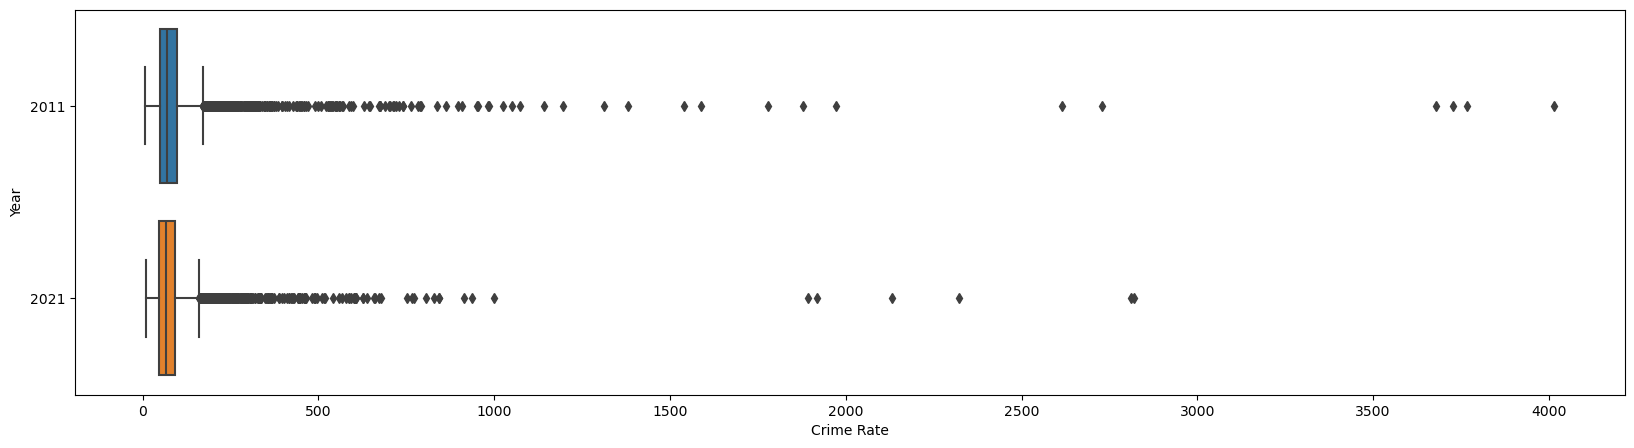

In [44]:
# Plot Code

plt.figure(figsize=(20,5))
crime_boxplot = seaborn.boxplot(data=crime_box_df, x="Crime Rate", y="Year", orient="h")

In [45]:
# Boxplot Statistics for 2011

# Selection of Relevant Columns

crime_2011_stats = crime_final[['LSOA Code', '2011 Crime/1000 people']]

# Drop of NaN and inf values

crime_2011_stats = crime_2011_stats[np.isfinite(crime_2011_stats['2011 Crime/1000 people'])]

# Calculation of median, LQ and UQ

crime_2011_median = crime_2011_stats['2011 Crime/1000 people'].median()
crime_2011_LQ = np.percentile(crime_2011_stats['2011 Crime/1000 people'],25)
crime_2011_UQ = np.percentile(crime_2011_stats['2011 Crime/1000 people'],75)
crime_2011_LW = crime_2011_LQ - (1.5 * (crime_2011_UQ - crime_2011_LQ))
crime_2011_UW = crime_2011_UQ + (1.5 * (crime_2011_UQ - crime_2011_LQ))

print("2011 Crime Boxplot Statistics")
print("Lower Whisker:", round(crime_2011_LW,2), "(this can be interpreted as 0 because values can not be negative)")
print("Lower Quartile:", round(crime_2011_LQ,2))
print("Median:", round(crime_2011_median,2))
print("Upper Quartile:", round(crime_2011_UQ,2))
print("Upper Whisker:", round(crime_2011_UW,2))
print("Number of Outliers:", sum(crime_2011_stats['2011 Crime/1000 people'] > crime_2011_UW))


2011 Crime Boxplot Statistics
Lower Whisker: -23.91 (this can be interpreted as 0 because values can not be negative)
Lower Quartile: 48.91
Median: 68.89
Upper Quartile: 97.46
Upper Whisker: 170.28
Number of Outliers: 398


In [46]:
# Boxplot Statistics for 2021

# Selection of Relevant Columns

crime_2021_stats = crime_final[['LSOA Code', '2021 Crime/1000 people']]

# Drop of NaN and inf values

crime_2021_stats = crime_2021_stats[np.isfinite(crime_2021_stats['2021 Crime/1000 people'])]

# Calculation of median, LQ and UQ

crime_2021_LQ = np.percentile(crime_2021_stats['2021 Crime/1000 people'],25)
crime_2021_UQ = np.percentile(crime_2021_stats['2021 Crime/1000 people'],75)
crime_2021_median = crime_2021_stats['2021 Crime/1000 people'].median()
crime_2021_LW = crime_2021_LQ - (1.5 * (crime_2021_UQ - crime_2021_LQ))
crime_2021_UW = crime_2021_UQ + (1.5 * (crime_2021_UQ - crime_2011_LQ))

print("2021 Crime Boxplot Statistics")
print("Lower Whisker:", round(crime_2021_LW,2), "(this can be interpreted as 0 because values can not be negative)")
print("Lower Quartile:", round(crime_2021_LQ,2))
print("Median:", round(crime_2021_median,2))
print("Upper Quartile:", round(crime_2021_UQ,2))
print("Upper Whisker:", round(crime_2021_UW,2))
print("Number of Outliers:", sum(crime_2021_stats['2021 Crime/1000 people'] > crime_2021_UW))

2021 Crime Boxplot Statistics
Lower Whisker: -21.87 (this can be interpreted as 0 because values can not be negative)
Lower Quartile: 46.61
Median: 65.1
Upper Quartile: 92.26
Upper Whisker: 157.27
Number of Outliers: 366


The main outtakes of the choropleth maps below are:

- Crime rates are the highest in London City LSOAs and its immediate surroundings. 

- A concentration of small LSOAs in South London have crime rates, potentially due to a small population. 

- Areas such as Brent and Ealing west of London City have higher than average crime rates.

- In West London, Hillingdon, where London Heathrow Airport is situated, has a high crime rate.

- To the north, Endfield has a medium-high crime rate increasing from 2011 to 2021.

- Areas to the east bounding the River Thames, such as Havering, Barking and Dagenham, and Newham have medium-high crime rates.

- In south-east London, Bromley has medium-high crime rates increasing from 2011 to 2021.

In [47]:
# Replace of inf and NaN values in CrimeMap_2011. 

CrimeMap_2011=CrimeMap_2011.replace([np.inf, np.NAN],0)

In [48]:
# Classification using Fisher Jenks

crime2011_fisher = mapclassify.FisherJenks(CrimeMap_2011['2011 Crime/1000 people'], k=6)
crime2011_fisher

FisherJenks

     Interval        Count
--------------------------
[   0.00,   88.20] |  3450
(  88.20,  199.61] |  1259
( 199.61,  469.84] |   216
( 469.84, 1072.09] |    54
(1072.09, 1973.06] |     9
(1973.06, 4015.62] |     6

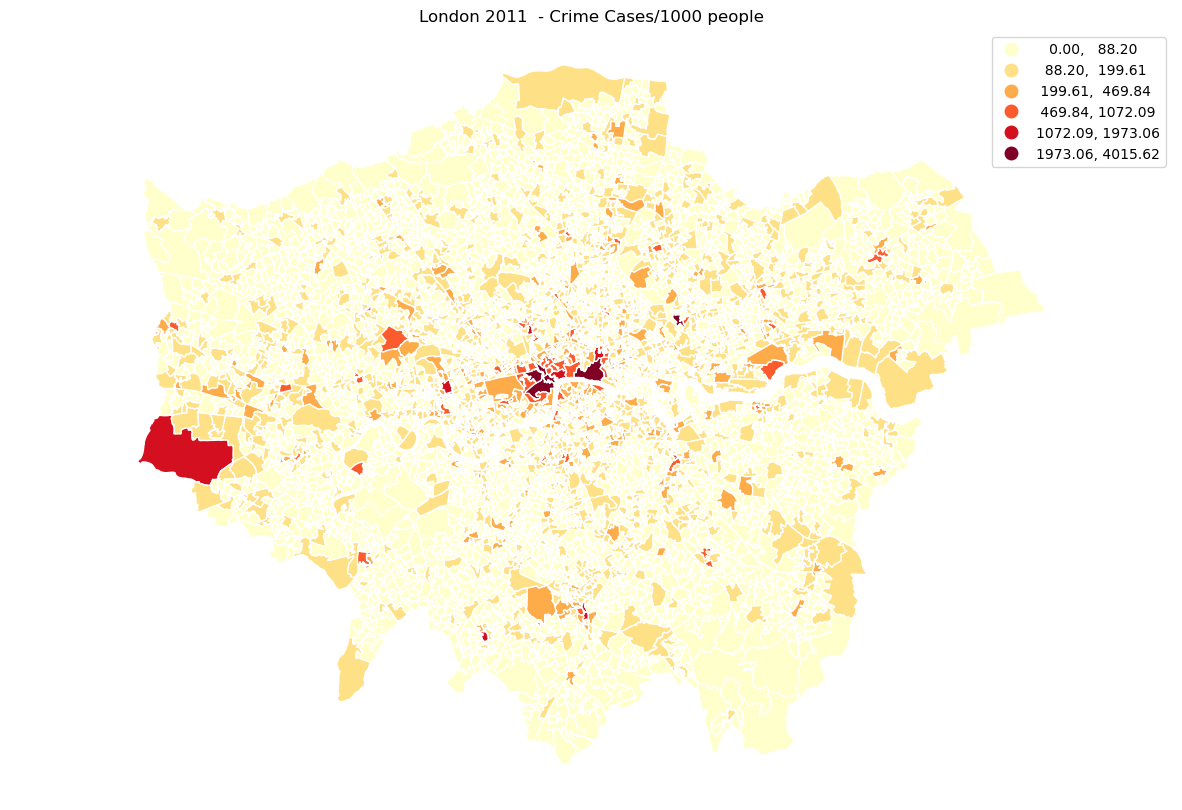

In [49]:
# Plot of 2011 Crime

f, ax = plt.subplots(1, figsize=(15, 10)) 
CrimeMap_2011.plot(ax=ax, column='2011 Crime/1000 people', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white')

ax.set_axis_off() 
ax.set_title('London 2011  - Crime Cases/1000 people') 
plt.axis('equal') 
plt.show()

In [50]:
# Replace of inf and NaN values in CrimeMap_2021. THIS COULD BE DONE EARLIER.

CrimeMap_2021=CrimeMap_2021.replace([np.inf, np.NAN],0)

In [51]:
# Classification using Fisher Jenks

crime2021_fisher = mapclassify.FisherJenks(CrimeMap_2021['2021 Crime/1000 people'], k=6)
crime2021_fisher

FisherJenks

     Interval        Count
--------------------------
[   8.04,   70.48] |  2822
(  70.48,  135.36] |  1663
( 135.36,  269.81] |   387
( 269.81,  517.34] |    87
( 517.34,  998.35] |    29
( 998.35, 2820.18] |     6

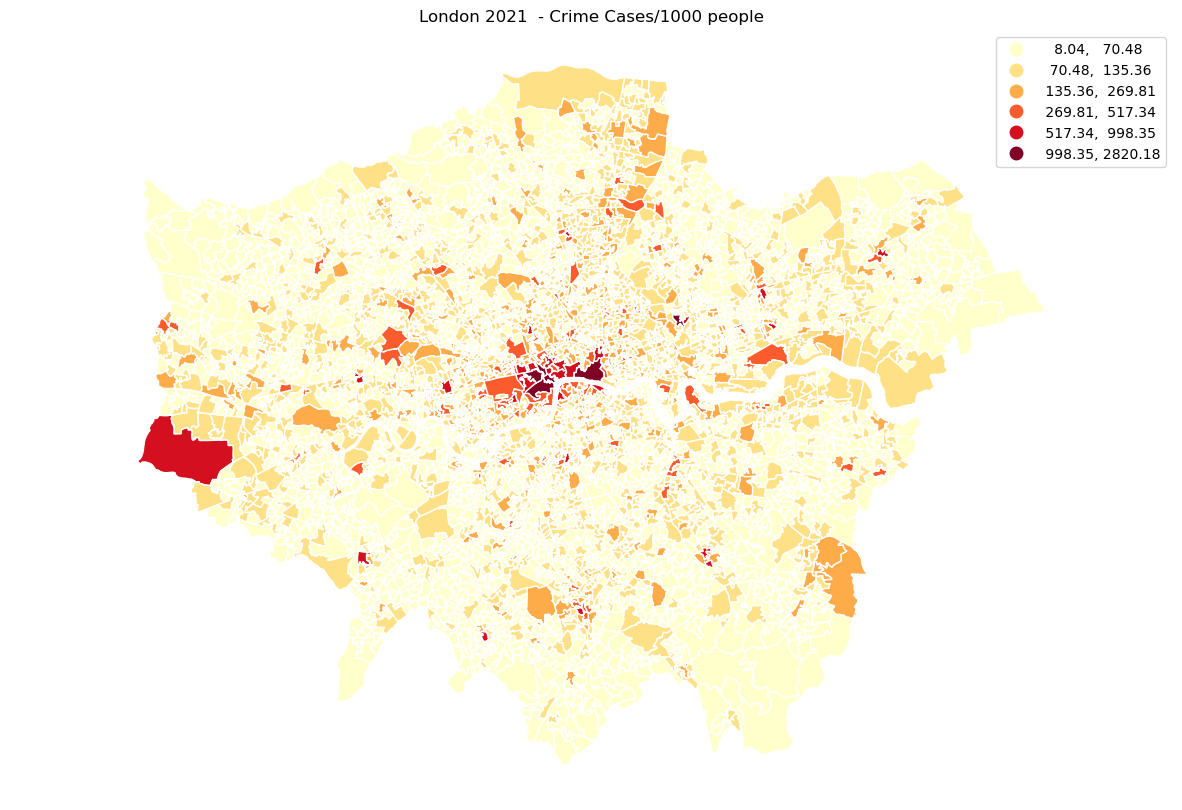

In [52]:
# Plot of 2021 Crime

f, ax = plt.subplots(1, figsize=(15, 10)) 
CrimeMap_2021.plot(ax=ax, column='2021 Crime/1000 people', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white')

ax.set_axis_off() 
ax.set_title('London 2021  - Crime Cases/1000 people') 
plt.axis('equal') 
plt.show()

#### Data Correlation

The analysis of the relationship between crime rates and occupational demographics reveals intriguing patterns across both 2011 and 2021 datasets. In examining the proportion of individuals in various occupational categories against crime rates per capita, several noteworthy trends emerge. Notably, for white-collar occupations, there appears to be a lack of clear positive correlation with crime rates in both years. Despite this, a slightly stronger positive correlation is observed between immigrants opting for white-collar jobs and crime rates in 2021. This suggests a nuanced relationship between white-collar employment and crime rates that warrants further investigation.

Similarly, the analysis for blue-collar occupations indicates a lack of significant positive correlation with crime rates in both 2011 and 2021. However, immigrants appear to be more inclined towards blue-collar occupations compared to white-collar jobs in both years. Despite this trend, the relationship between blue-collar employment and crime rates remains complex, with no clear pattern of influence observed. This highlights the multifaceted nature of the relationship between occupational demographics and crime rates, requiring comprehensive exploration to uncover underlying dynamics.

Conversely, a negative correlation is evident between the proportion of individuals in elementary occupations and crime rates in both 2011 and 2021. Despite this negative correlation, the absolute number of crimes reported for individuals in elementary occupations remains high, indicating a potential discrepancy between correlation and absolute impact. Additionally, a positive correlation is observed between immigrants and elementary occupations, suggesting a preference for such jobs among immigrants. However, the intricate intersection between crime rates, immigrant population, and elementary occupation lines underscores the complexity of this relationship, necessitating further research to elucidate underlying factors.

In [53]:
crime_final.columns

Index(['LSOA Code', 'LSOA_Crime2011', 'LSOA_Crime2021', '2011 Population',
       '2011 Non UK Percentage', '2021 Population', '2021 Non UK Percentage',
       '2011 Crime/1000 people', '2021 Crime/1000 people',
       'White Collar Sum 2011', 'White Collar Prop 2011',
       'Blue Collar Sum 2011', 'Blue Collar Prop 2011', 'Elementary Sum 2011',
       'Elementary Prop 2011', 'White Collar Sum 2021',
       'White Collar Prop 2021', 'Blue Collar Sum 2021',
       'Blue Collar Prop 2021', 'Elementary Sum 2021', 'Elementary Prop 2021'],
      dtype='object')

In [54]:
def divide_columns(row):
    # Check if denominator is zero
    if row['2011 Population'] == 0:
        return 0  # Return 0 if denominator is zero
    else:
        return row['LSOA_Crime2011'] / row['2011 Population']

# Apply the function to create a new column
crime_final['Crime 2011 / pop'] = crime_final.apply(divide_columns, axis=1)


In [55]:
def divide_columns(row):
    # Check if denominator is zero
    if row['2021 Population'] == 0:
        return 0  # Return 0 if denominator is zero
    else:
        return row['LSOA_Crime2021'] / row['2021 Population']

# Apply the function to create a new column
crime_final['Crime 2021 / pop'] = crime_final.apply(divide_columns, axis=1)

In [56]:
pd.DataFrame.iteritems = pd.DataFrame.items #workaround due to version changes of Databricks Runtime

sampled_df = crime_final.sample(n=500, random_state=42)
fig10 = px.parallel_coordinates(sampled_df,
                            dimensions=['2011 Non UK Percentage', 'Crime 2011 / pop', 'White Collar Prop 2011' ],
                            color='Crime 2011 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale=('#556270', '#4ECDC4', '#C7F464'))  # Change the color scale if needed))
fig10.show()

In [57]:
pd.DataFrame.iteritems = pd.DataFrame.items #workaround due to version changes of Databricks Runtime

fig11 = px.parallel_coordinates(sampled_df,
                            dimensions=['2011 Non UK Percentage',  'Crime 2011 / pop' ,'Blue Collar Prop 2011'],
                            color='Crime 2011 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale='Viridis')  # Change the color scale if needed)
fig11. show()


In [58]:
pd.DataFrame.iteritems = pd.DataFrame.items #workaround due to version changes of Databricks Runtime

fig12 = px.parallel_coordinates(sampled_df,
                            dimensions=['2011 Non UK Percentage' , 'Crime 2011 / pop','Elementary Prop 2011'],
                            color='Crime 2011 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale=('Inferno'))  # Change the color scale if needed))
fig12. show()

In [59]:
pd.DataFrame.iteritems = pd.DataFrame.items #workaround due to version changes of Databricks Runtime

fig13 = px.parallel_coordinates(sampled_df,
                            dimensions=['2021 Non UK Percentage', 'Crime 2021 / pop', 'White Collar Prop 2021' ],
                            color='Crime 2021 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale=('#556270', '#4ECDC4', '#C7F464'))  # Change the color scale if needed))
fig13. show()

In [60]:
pd.DataFrame.iteritems = pd.DataFrame.items #workaround due to version changes of Databricks Runtime

fig14 = px.parallel_coordinates(sampled_df,
                            dimensions=['2021 Non UK Percentage', 'Crime 2021 / pop', 'Blue Collar Prop 2021' ],
                            color='Crime 2021 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale='Viridis')  # Change the color scale if needed)
fig14. show()


In [61]:
pd.DataFrame.iteritems = pd.DataFrame.items #workaround due to version changes of Databricks Runtime

fig15 = px.parallel_coordinates(sampled_df,
                            dimensions=['2021 Non UK Percentage', 'Crime 2021 / pop','Elementary Prop 2011' ],
                            color='Crime 2021 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale=('Inferno'))  # Change the color scale if needed))
fig15. show()

### Relationship between Crime and Non-UK Population

Detailed Analysis:-
Analysing the crime rate & relationship with non-UK population the following steps were carried out:-
1. Set inf or NaNs to 0, which were due to 37  2011 LSOA populations being unavailable from the census
2. Starting with the crime rate & non-UK population birth rates, our calculations shows:- 
    (a) correlation between the 2 columns,  was found to be 0.197 and 0.239 for 2011 and 2021 respectively, demonstrating a weak positive correlation between the crime rate and non-UK birth rates. 
    (b) The 2011 non-UK birth rate IQR per LSOA was calculated as 0.258 to 0.468  with Min:0.036, Max:0.823,  and Median:0.373.  
        By 2021, there was a slight increase in the equivalent rates with IQR between 0.309 and 0.495 with  Min:0.045, Q1: Max:0.816 and Median increased by over 3 percentage points to 0.408. These are shown in the violin plot below
3. Ranked crime rates & non-UK population rates in descending order, for use in further analysis.
4. Sorted the crime rates in descending order (so LSOA with highest crime rates were first), we found for 2011
    (a)1 LSOA in East London (Newham) followed by Westminister (tourist and business area in Central London) & City of London had the highest crime rates.  Looking at crime rank versus non-UK population rank on their own, there's no apparent correlation for Westminister or City of London. An implication of this could be that there's other factors here, which would require further data to analyse e.g. being a tourist\business hotspot there's a greater footfall than other LSOAs or non residents could be higher crime targets.  In the case of Newham which has the 11th highest non-UK population rank (& Lewisham 19th) we found in 2011 the population was less than 1/10th that of the LSOA 2011 population mean (1637) . These 2 LSOAs appear to be outliers.
    (b) The LSOA's with the lowest crime rates were also in areas with the lower non-UK population rank. LSOAs in Bexley, Bromley and Kingston upon Thames were the LSOAs with the lowest crime rates for 2011. 
    (c) All 4 classification schemes discussed in lectures were plotted and Fischer Jenks was found to have the lowest ADCM for 2011 crime rate data so this scheme was used for further analysis and plots e.g cloropleth maps have been created to show the breakdown by LSOA.
    (d) We also observed a number  of neighbouring LSOAs having similar crime rates, as demonstrated in the Fischer Jenks plots below.


Repeating steps 4 for 2021 the findings were as follows:-
(a) Westminster LSOAs now feature even more heavily in the top 10 LSOAs with the highest crime rates (up from 4/10 to 7/10). Newham and City of London LSOAs also continue to feature in the highest crime rate areas
(b) Areas with the lowest crime rates in 2021 continue to be LSOAs with a low non-UK population rate. This time Croydon has replaced Kingston upon Thames in the lowest crime areas. One interesting callout is in Croydon where there's an LSOA with a high non-UK percentage but a low crime rate which may indicate (deeper analysis required) that crime rates in surrounding LSOAs are a better indicator of crime.
(c) As per 2011, Fischer Jenks was found to have the lowest ADCM for 2011 crime rate data so this scheme was used for further analysis & plots
(d) Similar to 2011, we also observed a number  of neighbouring LSOAs having similar crime rates, as demonstrated in the Fischer Jenks plots below.

Conclusions:-
In summary, for both 2011 and 2021 we can see clusters of LSOAs with both highest and lowest crime rates, with the finding that non-UK population isn't significant in areas with high crime rates but is in ares of low crime rates. As mentioned above, aside from 2 outliers, the LSOAs with the highest crime rates are in Tourist\Business areas of central London e.g. Westminster which requires further investigation to understand if there's other contributing factors.

Creating barplot of all 4 classification schemes (Quantiles, EqualInterval, StdMean and Fisher-Jenks) discussed in lectures. This shows that Fisher-Jenks has the lowest absolute deviation around class medians (ADCM), for both 2011 and 2021 so we'll use this classification scheme for the crime versus non-UK birth analysis. Also, ADCM is about 25% lower in 2021 than 2011, consistent with lower crime rates, particularly at the upper end of the scale.

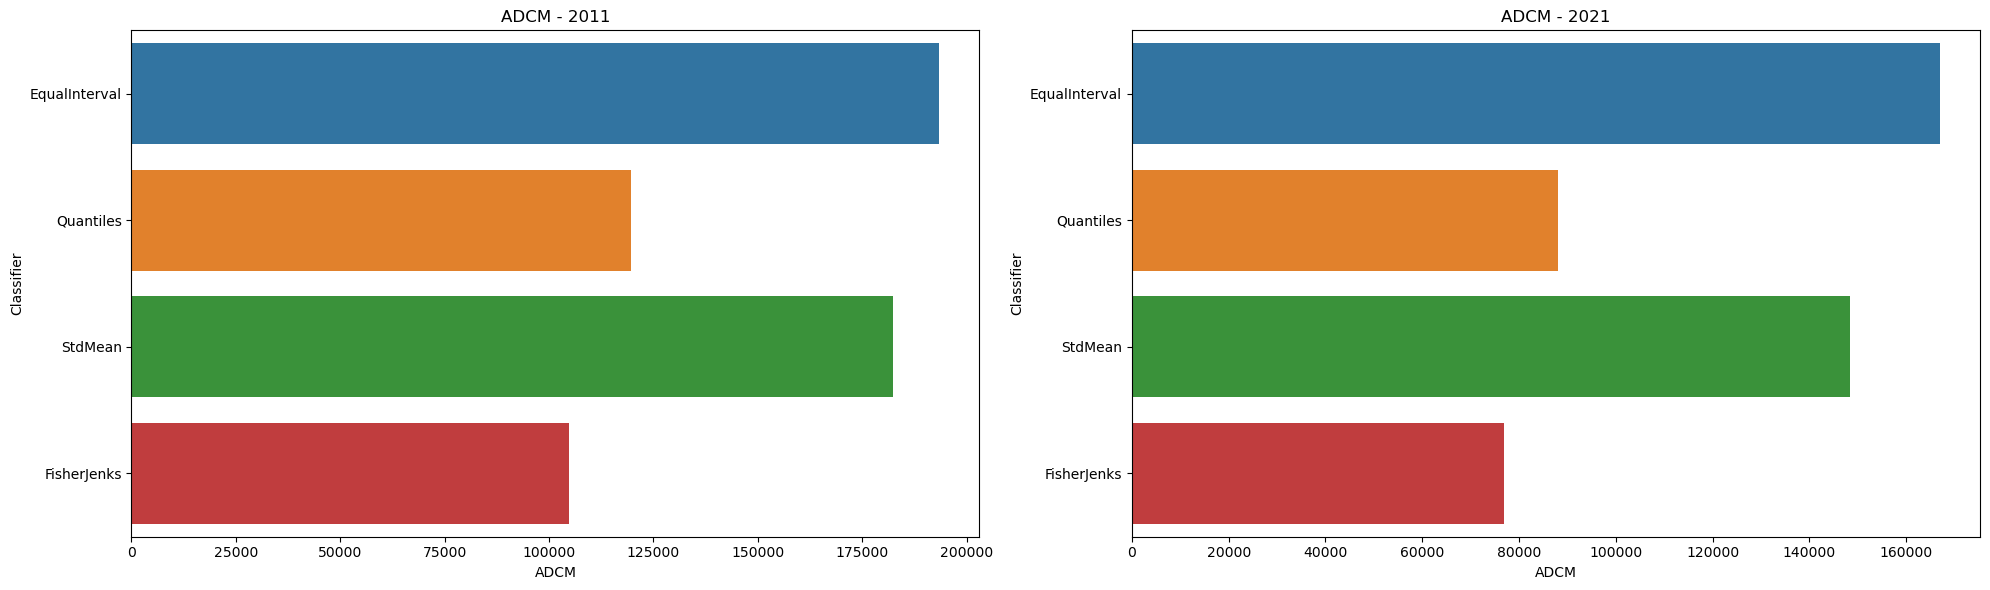

In [62]:
q5 = mapclassify.Quantiles(CrimeMap_2011['2011 Crime/1000 people'], k=6)
q5

msd = mapclassify.StdMean(CrimeMap_2011['2011 Crime/1000 people'])
msd

ei5 = mapclassify.EqualInterval(CrimeMap_2011['2011 Crime/1000 people'], k=6)
ei5

q5_2021 = mapclassify.Quantiles(CrimeMap_2021['2021 Crime/1000 people'], k=6)
q5_2021

msd_2021 = mapclassify.StdMean(CrimeMap_2021['2021 Crime/1000 people'])
msd_2021

ei5_2021 = mapclassify.EqualInterval(CrimeMap_2021['2021 Crime/1000 people'], k=6)
ei5_2021


class5 = ei5, q5, msd, crime2011_fisher
fits = np.array([ c.adcm for c in class5])
data = pd.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']

class5_2021 = ei5_2021, q5_2021, msd_2021, crime2021_fisher
fits_2021 = np.array([ c.adcm for c in class5_2021])
data_2021 = pd.DataFrame(fits_2021)
data_2021['classifier'] = [c.name for c in class5_2021]
data_2021.columns = ['ADCM', 'Classifier']

# Create a figure and two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first set of data
seaborn.barplot(y='Classifier', x='ADCM', data=data, ax=axes[0])
axes[0].set_title('ADCM - 2011')

# Plot the second set of data
seaborn.barplot(y='Classifier', x='ADCM', data=data_2021, ax=axes[1])
axes[1].set_title('ADCM - 2021')

# Adjust layout
plt.tight_layout()

# Show the plots.
plt.show()

This section shows statistics for crime rate versus non-UK birth rate (e.g. correlation), ranks the crime and non-UK birth rates, shows the highest and lowest rates and plots key data

Number of LSOAs for analysis:4994
POB_2011 statistics: Min:0.036, Q1:0.258 , Median:0.373, Q3:0.468, Max:0.823
Mean Non UK population POB_2011  is 1636.752302763316
Mean Non UK population percentage for POB_2011  is 0.3629362549727461
Variance Non UK population percentage for POB_2011  is 0.021107904939382204
Number of null population percentage values for POB_2011  is 37
Count of LSOAs with population percentage values  for POB_2011  is 4957
POB_2021 statistics: Min:0.045, Q1:0.309 , Median:0.408, Q3:0.495, Max:0.816
Mean Non UK population POB_2021  is 1762.0935122146575
Mean Non UK population percentage for POB_2021  is 0.40152347080770884
Variance Non UK population percentage for POB_2021  is 0.017587094682892837
Number of null population percentage values for POB_2021  is 0
Count of LSOAs with population percentage values  for POB_2021  is 4994
Correlation between crime rate and 2011 non-UK population is:0.197
LSOAs with highest crime rate in 2011:
      2011 Crime/1000 people  201

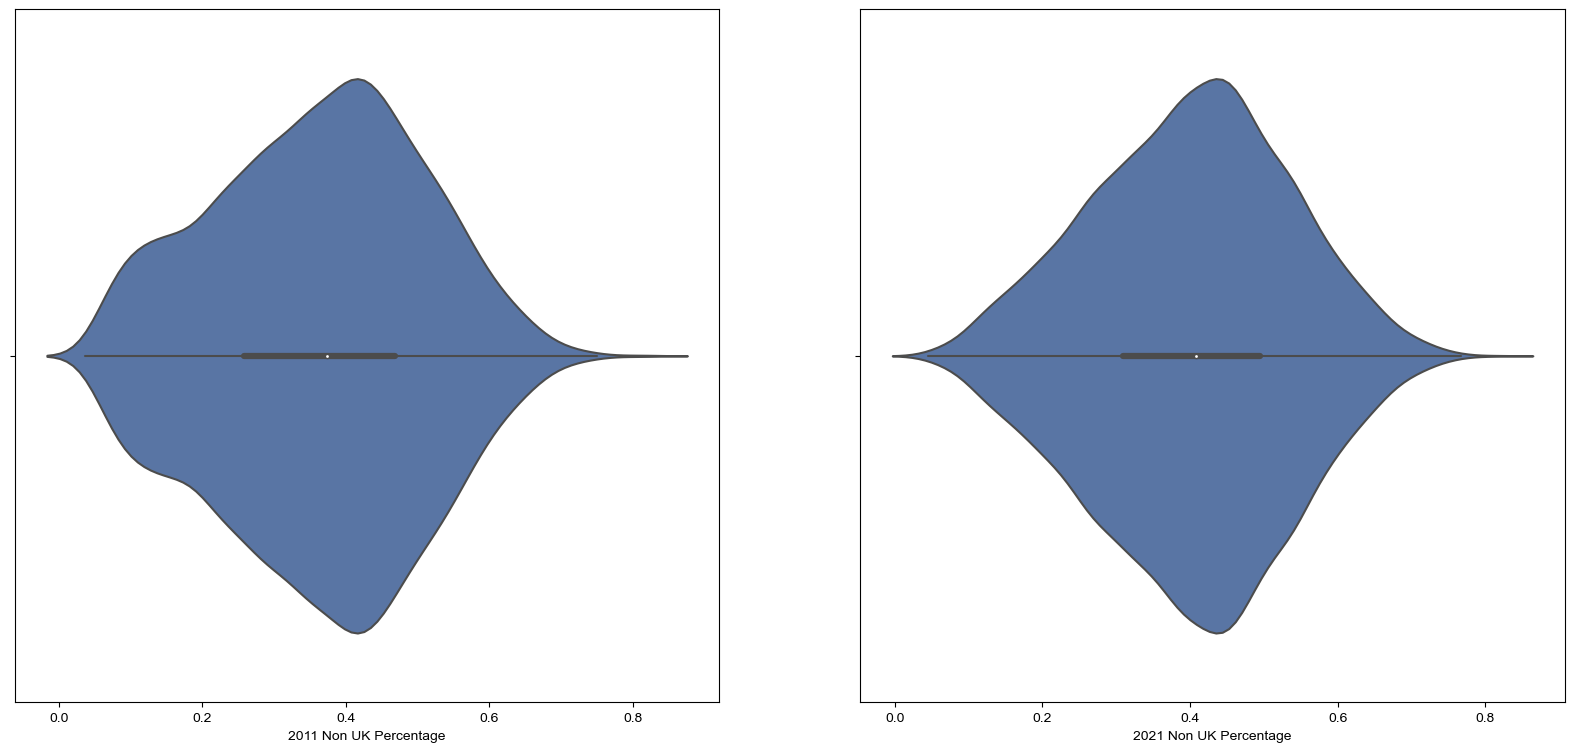

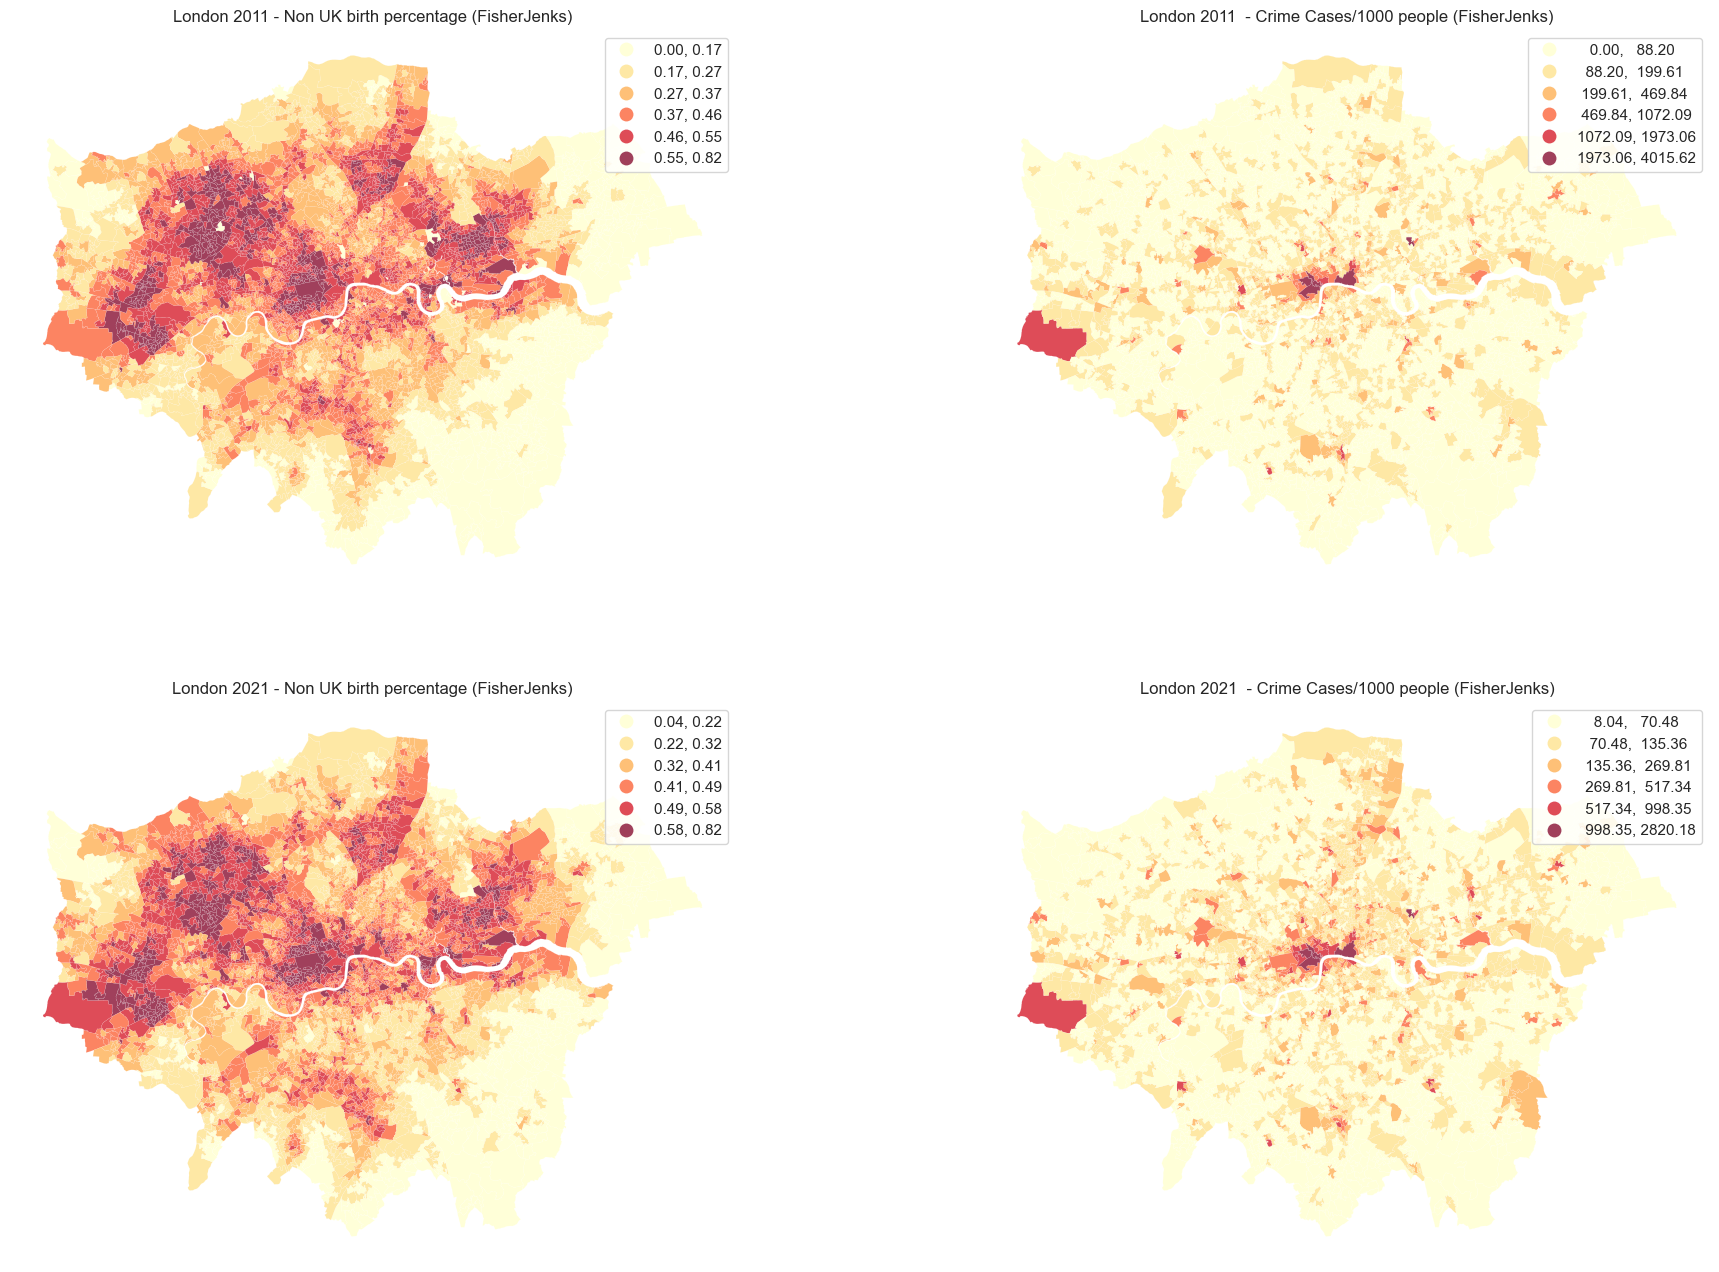

In [63]:
pd.set_option('display.width', 600)
print("Number of LSOAs for analysis:" + str(len(CrimeMap_2011))) # 2011 and 2022 have the same number of LSOAs as we do comparisons between the 2 years

# Find mean, count and number of null values for each dataset

yearnum = int()

for n in [POB_2011, POB_2021]:
    data_name = [name for name, obj in locals().items() if obj is n][0]
    n['Non UK Percentage'] = pd.Series(n['Non UK Percentage'])
    #Get summary statistics
    #%8.2f
    fivenum_summary = np.percentile(n['Non UK Percentage'].astype(float).dropna(), [0, 25, 50, 75, 100])
    print("{} statistics:".format(data_name) + " Min:{}".format(round(fivenum_summary[0],3)) + ", Q1:{} ".format(round(fivenum_summary[1],3)) + ", Median:{}".format(round(fivenum_summary[2],3))  + ", Q3:{}".format(round(fivenum_summary[3],3)) + ", Max:{}".format(round(fivenum_summary[4],3)))
    print("Mean Non UK population {} ".format(data_name) + " is "+  str(n['All Usual residents'].mean()))
    print("Mean Non UK population percentage for {} ".format(data_name) + " is "+  str(n['Non UK Percentage'].mean()))
    print("Variance Non UK population percentage for {} ".format(data_name) + " is "+  str(n['Non UK Percentage'].var()))
    print("Number of null population percentage values for {} ".format(data_name) + " is "+  str(n['Non UK Percentage'].isnull().sum()))
    print("Count of LSOAs with population percentage values  for {} ".format(data_name) + " is "+  str(n['Non UK Percentage'].count()))


CrimeMap_2011_corr = round(CrimeMap_2011['2011 Crime/1000 people'].corr(CrimeMap_2011['2011 Non UK Percentage']),3)

print("Correlation between crime rate and 2011 non-UK population is:{}".format(CrimeMap_2011_corr))

#Setting inf and null as 0. These were due to missing data
CrimeMap_2011_sorted_df = pd.DataFrame(CrimeMap_2011[['2011 Crime/1000 people','2011 Non UK Percentage', '2011 Population', 'LSOA Code','LSOA21NM']])
CrimeMap_2011_sorted_df=CrimeMap_2011_sorted_df.replace([np.inf, np.NAN],0)

#sorting by 2011 Non UK Percentage is descending order in order to create a new column ('Non UK Population Rank') which ranks the LSOA by non-UK population percentage for later analysis
CrimeMap_2011_sorted_df = CrimeMap_2011_sorted_df.sort_values(by='2011 Non UK Percentage',ascending=False )
CrimeMap_2011_sorted_df['Non UK Population Rank'] = range(1,len(CrimeMap_2011_sorted_df)+1)

##excluding 0s as we marked inf\nulls as 0. 
CrimeMap_2011_sorted_df_filtered = CrimeMap_2011_sorted_df[CrimeMap_2011_sorted_df['2011 Crime/1000 people'] > 0]
CrimeMap_2011_sorted_df = CrimeMap_2011_sorted_df.sort_values(by='2011 Crime/1000 people',ascending=False )
CrimeMap_2011_sorted_df['Crime Rank'] = range(1,len(CrimeMap_2011_sorted_df)+1)
CrimeMap_2011_sorted_df_filtered = CrimeMap_2011_sorted_df[CrimeMap_2011_sorted_df['2011 Crime/1000 people'] > 0] 

#Sort 2011 crime rates in descending order for next step to show highest and lowest crime rates
CrimeMap_2011_sorted_df = CrimeMap_2011_sorted_df.sort_values(by='2011 Crime/1000 people',ascending=False )
CrimeMap_2011_sorted_df_filtered = CrimeMap_2011_sorted_df[CrimeMap_2011_sorted_df['2011 Crime/1000 people'] > 0]

print("LSOAs with highest crime rate in 2011:")
print(CrimeMap_2011_sorted_df_filtered.head(10))

print("LSOAs with lowest crime rate in 2011:")
print(CrimeMap_2011_sorted_df_filtered.tail(10))

CrimeMap_2021_corr = round(CrimeMap_2021['2021 Crime/1000 people'].corr(CrimeMap_2021['2021 Non UK Percentage']),3) 

print("Correlation between crime rate and 2021 non-UK population is:{}".format(CrimeMap_2021_corr))


#Setting inf and null as 0. These were due to missing data
CrimeMap_2021_sorted_df = pd.DataFrame(CrimeMap_2021[['2021 Crime/1000 people','2021 Non UK Percentage','2021 Population', 'LSOA Code','LSOA21NM']])
CrimeMap_2021_sorted_df=CrimeMap_2021_sorted_df.replace([np.inf, np.NAN],0)

#sorting by 2021 Non UK Percentage is descending order in order to create a new column ('Non UK Population Rank') which ranks the LSOA by non-UK population percentage for later analysis
CrimeMap_2021_sorted_df = CrimeMap_2021_sorted_df.sort_values(by='2021 Non UK Percentage',ascending=False )
CrimeMap_2021_sorted_df['Non UK Population Rank'] = range(1,len(CrimeMap_2021_sorted_df)+1)

##excluding 0s as we marked inf\nulls as 0. 
CrimeMap_2021_sorted_df_filtered = CrimeMap_2021_sorted_df[CrimeMap_2021_sorted_df['2021 Crime/1000 people'] > 0]
CrimeMap_2021_sorted_df = CrimeMap_2021_sorted_df.sort_values(by='2021 Crime/1000 people',ascending=False )
CrimeMap_2021_sorted_df['Crime Rank'] = range(1,len(CrimeMap_2021_sorted_df)+1)
CrimeMap_2021_sorted_df_filtered = CrimeMap_2021_sorted_df[CrimeMap_2021_sorted_df['2021 Crime/1000 people'] > 0] 

#Sort 2021 crime rates in descending order for next step to show highest and lowest crime rates
CrimeMap_2021_sorted_df = CrimeMap_2021_sorted_df.sort_values(by='2021 Crime/1000 people',ascending=False )
CrimeMap_2021_sorted_df_filtered = CrimeMap_2021_sorted_df[CrimeMap_2021_sorted_df['2021 Crime/1000 people'] > 0]

print("LSOAs with highest crime rate in 2021:")
print(CrimeMap_2021_sorted_df_filtered.head(10))

print("LSOAs with lowest crime rate in 2021:")
print(CrimeMap_2021_sorted_df_filtered.tail(10))

##Violin plot showing percentage of non-UK birth population 2011 and 2021
f, axs = plt.subplots(1,2, figsize=(20, 9)) 
seaborn.set_theme(style="whitegrid")
bx_2011 = seaborn.violinplot(x=CrimeMap_2011_sorted_df_filtered['2011 Non UK Percentage'],ax=axs[0])
bx_2021 = seaborn.violinplot(x=CrimeMap_2021_sorted_df_filtered['2021 Non UK Percentage'],ax=axs[1])


#Creating FisherJenks classification scheme plots showing the Non-UK birth rates & crime rates per LSOA, for 2011 and 2021 
f, axs = plt.subplots(2,2, figsize=(24, 16)) 
ax1, ax2, ax3, ax4 = axs[0,0],axs[0,1],axs[1,0],axs[1,1]

CrimeMap_2011.plot(ax=ax1,column='2011 Non UK Percentage', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white',linewidth=0.1, alpha=0.75)
ax1.set_axis_off() 
ax1.set_aspect('equal')
ax1.set_title('London 2011 - Non UK birth percentage (FisherJenks)') 
#plt.axis('equal') 

CrimeMap_2011.plot( ax=ax2,column='2011 Crime/1000 people', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white',linewidth=0.1, alpha=0.75)
ax2.set_axis_off() 
ax2.set_aspect('equal')
ax2.set_title('London 2011  - Crime Cases/1000 people (FisherJenks)') 
#plt.axis('equal') 
#plt.show()

CrimeMap_2021.plot(ax=ax3,column='2021 Non UK Percentage', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white',linewidth=0.1, alpha=0.75)
ax3.set_axis_off() 
ax3.set_aspect('equal')
ax3.set_title('London 2021 - Non UK birth percentage (FisherJenks)') 

CrimeMap_2021.plot( ax=ax4,column='2021 Crime/1000 people', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white',linewidth=0.1, alpha=0.75)
ax4.set_axis_off() 
ax4.set_aspect('equal')
ax4.set_title('London 2021  - Crime Cases/1000 people (FisherJenks)') 

plt.subplots_adjust(wspace=0.1)
plt.show()

#### Relationship between Crime and Occupation

In both 2011 and 2021, we see a strong inverse correlation between the number of white collars and each of other two groups, while the elementary workers' number has a positive, weaker correlation with white collars. In this case we decide to merge the white collar group and blue collar group. 

Even then, we cannot see a clear relationship between occupancy group rate and crime rate. Even if we can see a higher elementary occupation proportion may be correlated with a higher crime rate, the scales of change are seriously unmatched. In fact, for observances whose crime rates fall into either the IQR or fall out as outliers, they both tend to have a much wider range of occupancy rate, so we are not confident enough to determine any actual relationship between these two. 

As a side note, the non-UK residents percentage and Blue Collar Prop in both years seem to have a slightly negative correlation, meaning that areas with more percentage of immigrants may have less precentage of blue collars. This is perhaps because most blue collars in London are locals, and areas with more locals have necessarily less non-UK residents. There also could be a weak positive correlation between non-UK residents percentage and the elementary occupation rate, but this needs more future exploration. 

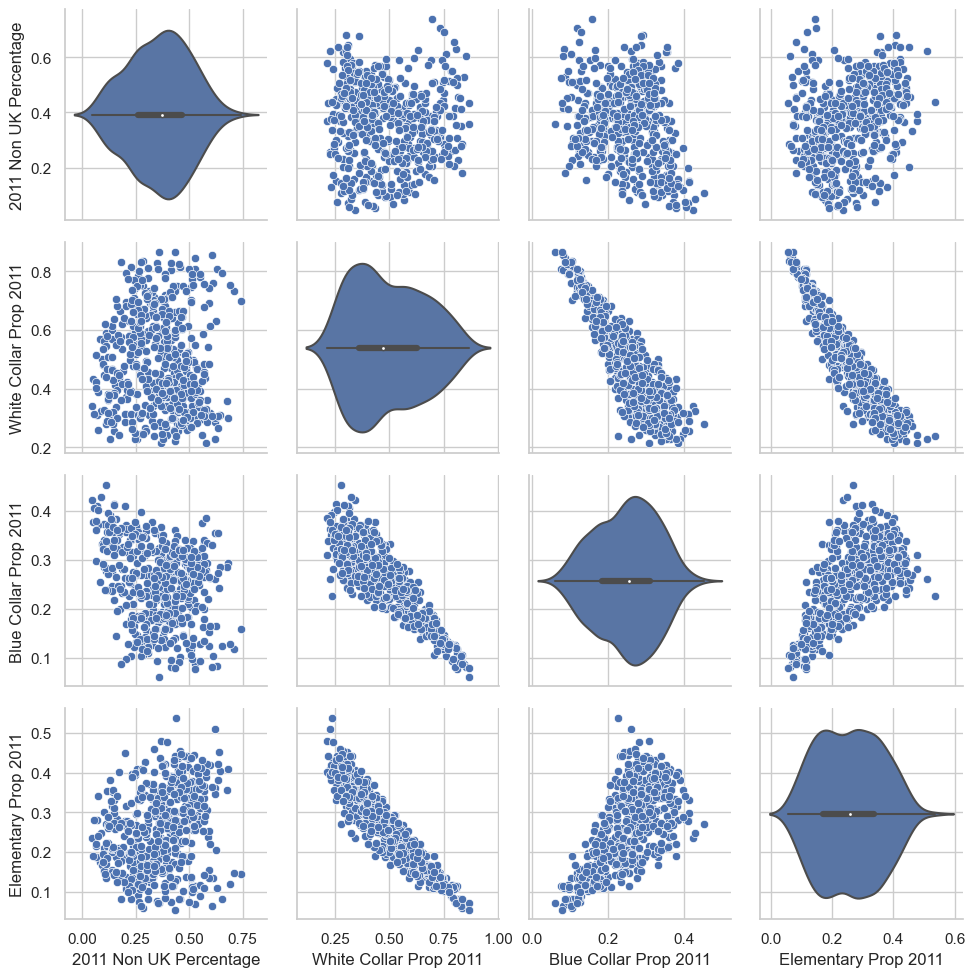

In [64]:
# We will look at the correlation between non-UK population ratio and different occupation groups in 2011.

fig = seaborn.PairGrid(sampled_df, vars = ['2011 Non UK Percentage', 'White Collar Prop 2011', 'Blue Collar Prop 2011', 'Elementary Prop 2011'])
fig.map_diag(seaborn.violinplot)
fig.map_offdiag(seaborn.scatterplot)


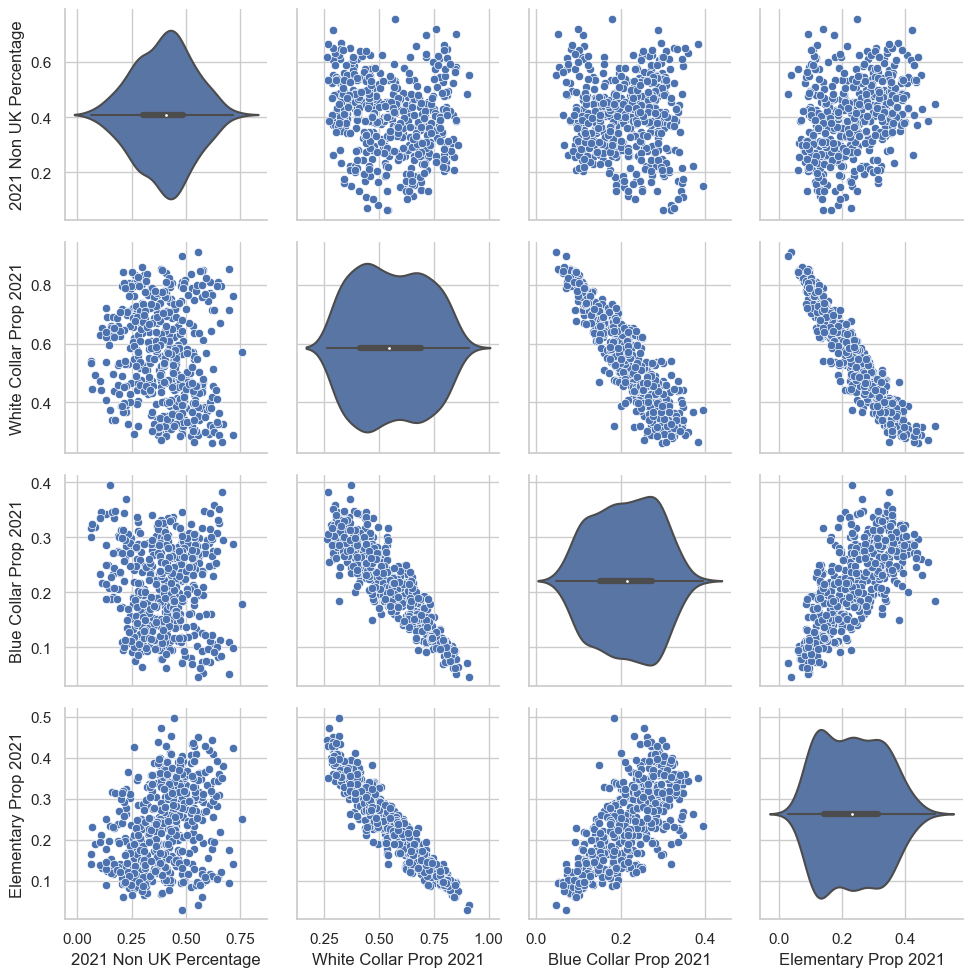

In [65]:
fig = seaborn.PairGrid(sampled_df, vars = ['2021 Non UK Percentage', 'White Collar Prop 2021', 'Blue Collar Prop 2021', 'Elementary Prop 2021'])
fig.map_diag(seaborn.violinplot)
fig.map_offdiag(seaborn.scatterplot)

In [66]:
# Since the White Collar Prop 2011 has a strong negative relation with both the Blue Collar Prop 2011 and the Elementary Prop 2011, and the Elementary Prop has a weaker positive correlation with the Blue Collar Prop, that means the Elementary Prop and the Blue Prop could be relatively independent of each other. We will now merge the White Collar Prop 2011 and Blue Collar Prop 2011, and draw a new parallel coordinate plot.


White_Blue_Collar_Prop_2011 = sampled_df['White Collar Prop 2011'] + sampled_df['Blue Collar Prop 2011']
tmp_df_2011 = pd.DataFrame({'White_Blue_Collar_Prop_2011': White_Blue_Collar_Prop_2011, 'Crime 2011 / pop': sampled_df['Crime 2011 / pop'], 'Elementary Prop 2011': sampled_df['Elementary Prop 2011']})

## Because now we have only two groups of occupation, and their sum is always 1, we can keep only one of them in the plot. We will keep the Elementary Prop 2011.

fig = px.parallel_coordinates(tmp_df_2011,
                            dimensions=['Elementary Prop 2011' , 'Crime 2011 / pop'],
                            color='Crime 2011 / pop',  # Change the color based on 'Crime 2011 / pop' column
                            color_continuous_scale=('Inferno'))
fig.show()

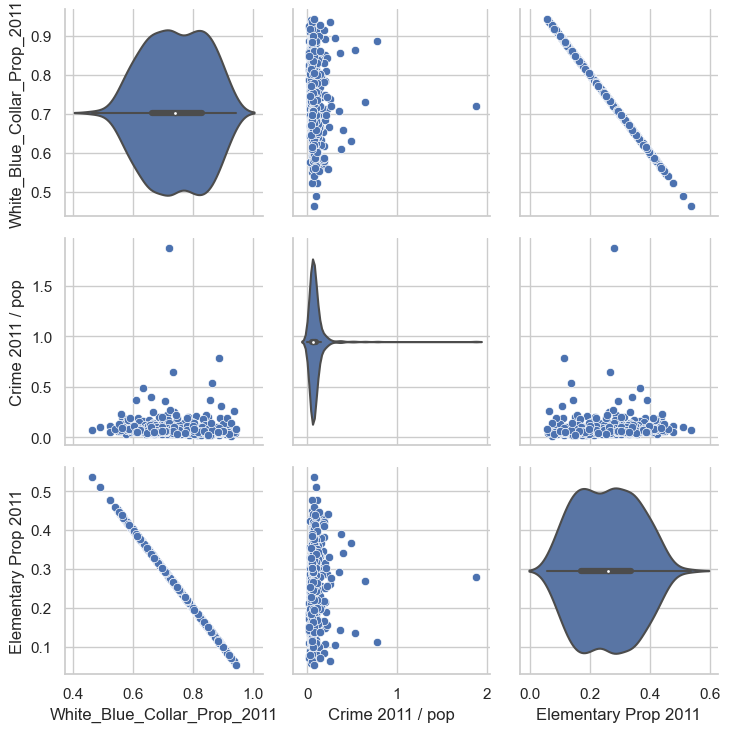

In [67]:
# We can also draw a pairgrid plot

fig = seaborn.PairGrid(tmp_df_2011, vars = ['White_Blue_Collar_Prop_2011', 'Crime 2011 / pop', 'Elementary Prop 2011'])
fig.map_diag(seaborn.violinplot)
fig.map_offdiag(seaborn.scatterplot)

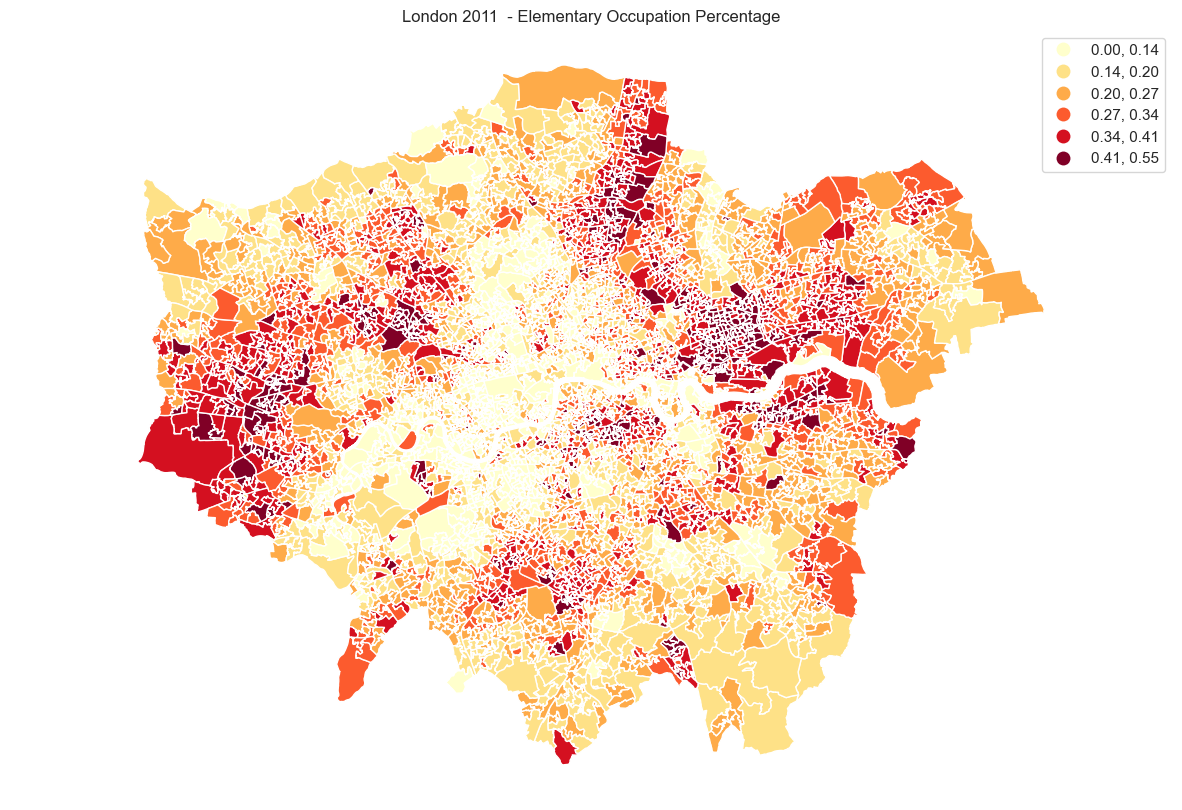

In [68]:
# To draw the map for this occupation group:

f, ax = plt.subplots(1, figsize=(15, 10)) 
CrimeMap_2011.plot(ax=ax, column='Elementary Prop 2011', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white')

ax.set_axis_off() 
ax.set_title('London 2011  - Elementary Occupation Percentage') 
plt.axis('equal') 
plt.show()

In [69]:
# Now we repeat same steps for the 2021 data. 

White_Blue_Collar_Prop_2021 = sampled_df['White Collar Prop 2021'] + sampled_df['Blue Collar Prop 2021']
tmp_df_2021 = pd.DataFrame({'White_Blue_Collar_Prop_2021': White_Blue_Collar_Prop_2021, 'Crime 2021 / pop': sampled_df['Crime 2021 / pop'], 'Elementary Prop 2021': sampled_df['Elementary Prop 2021']})

fig = px.parallel_coordinates(tmp_df_2021,
                            dimensions=['Elementary Prop 2021' , 'Crime 2021 / pop',],
                            color='Crime 2021 / pop',  # Change the color based on 'Crime 2021 / pop' column
                            color_continuous_scale=('Inferno'))
fig.show()

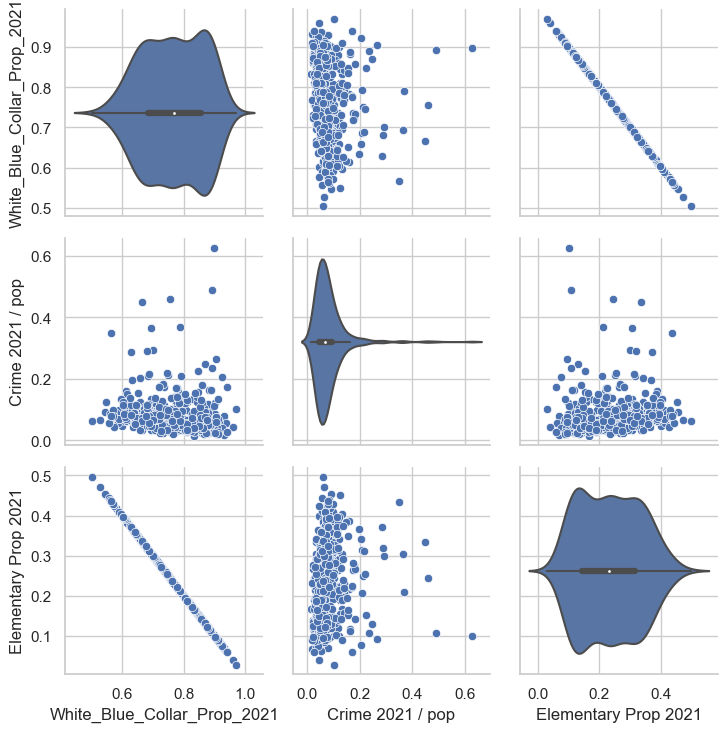

In [70]:
# We can also draw a pairgrid plot

fig = seaborn.PairGrid(tmp_df_2021, vars = ['White_Blue_Collar_Prop_2021', 'Crime 2021 / pop', 'Elementary Prop 2021'])
fig.map_diag(seaborn.violinplot)
fig.map_offdiag(seaborn.scatterplot)

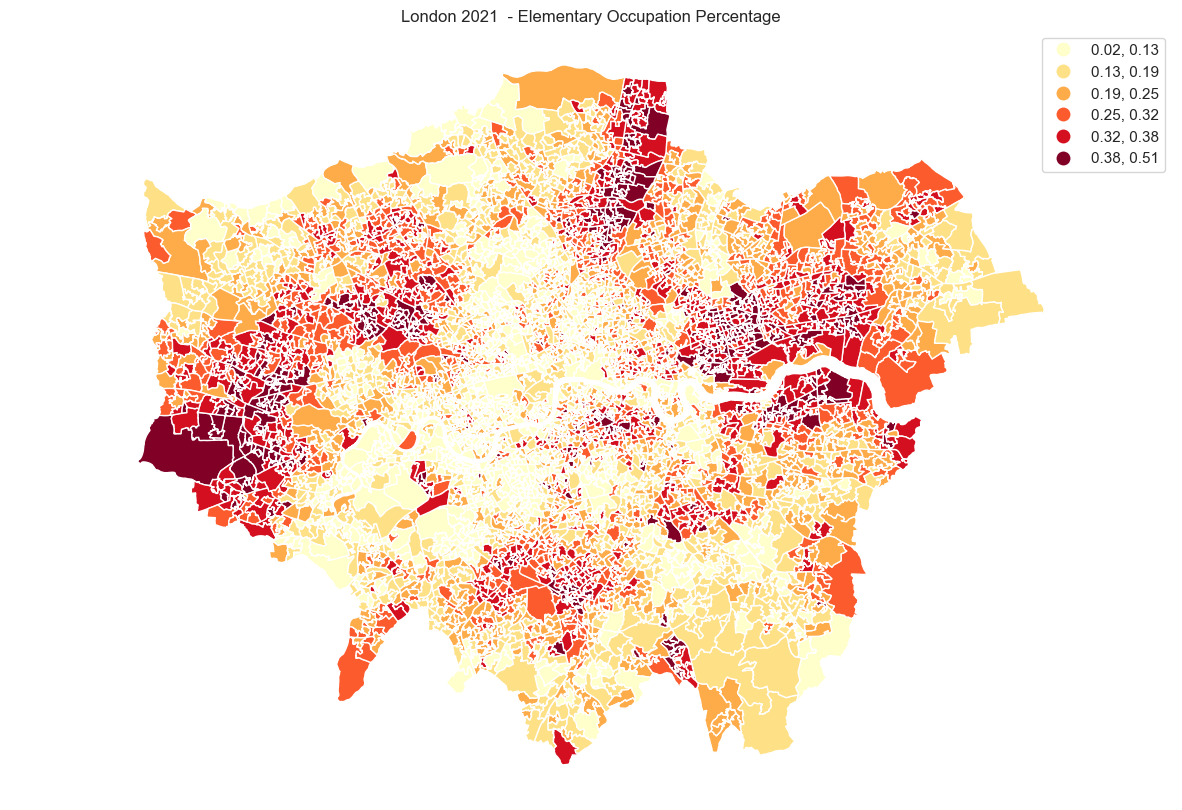

In [71]:
# To draw the map for this occupation group:

f, ax = plt.subplots(1, figsize=(15, 10)) 
CrimeMap_2021.plot(ax=ax, column='Elementary Prop 2021', legend=True, cmap='YlOrRd', scheme='FisherJenks', k=6, edgecolor='white')

ax.set_axis_off() 
ax.set_title('London 2021  - Elementary Occupation Percentage') 
plt.axis('equal') 
plt.show()

### Description of results and significance

The analysis of crime rates in relation to non-UK birth population for both 2011 and 2021 yields intriguing insights into the dynamics of urban demographics and criminal activity. 

A weak positive correlation is observed between crime rates and non-UK birth rates, with correlation coefficients of 0.197 and 0.239 for 2011 and 2021, respectively.However, upon ranking these variables, it becomes apparent that the majority of areas with the highest crime rates do not necessarily coincide with those with the highest non-UK birth rates. This suggests the presence of additional influential factors beyond demographic composition, such as tourism, in shaping crime rates. Noteworthy outliers include Newham and Lewisham, residential areas with high non-UK population ranks and crime rates, challenging conventional assumptions about urban crime demographics. Conversely, areas with low crime rates, such as Bexley and Havering, also exhibit low non-UK birth rates, except for select anomalies like a Croydon LSOA with high non-UK birth rates and low crime rates, emphasizing the nuanced interplay of demographic and criminal variables.

Furthermore, the analysis of occupational demographics vis-a-vis crime rates unveils intricate relationships across white-collar, blue-collar, and elementary occupation categories.

A strong inverse correlation emerged between white-collar employment and crime rates in both 2011 and 2021. This suggests areas with a higher concentration of professionals in finance, law, or business tend to experience lower crime levels. Potentially, these areas have better infrastructure, security measures, or stronger community cohesion, leading to lower crime opportunities.

Interestingly, no significant positive correlation was found between blue-collar employment and crime rates. Blue-collar jobs encompass manual labor roles in construction, transportation, or manufacturing. This finding challenges the stereotype that blue-collar jobs automatically lead to higher crime. It's possible that factors like job security, wages, and access to social services within these professions play a role in shaping local crime patterns. Additionally, immigrants often find themselves in blue-collar occupations due to language barriers or credential recognition challenges. Further research could explore if the non-UK resident percentage within blue-collar jobs influences crime rates differently compared to native-born residents in similar positions.

A weaker correlation was observed between elementary workers and crime rates. Elementary occupations include roles in cleaning, waiting tables, or basic customer service. This weaker correlation suggests that while some areas with high concentrations of elementary jobs might experience higher crime, it's not the sole determining factor. Notably, further exploration is warranted to elucidate potential correlations between non-UK residents' percentages, blue-collar employment rates, and elementary occupation rates, highlighting the need for ongoing research in this domain.

#### Conclusions

 The analysis reveals complex relationships between crime rates, non-UK birth population, and occupational demographics in London. Despite a weak positive correlation between crime rates and non-UK birth rates, the presence of additional influential factors underscores the multifaceted nature of urban crime dynamics. The consistency in crime rate distributions over time highlights the enduring nature of urban crime patterns, while spatial analysis through choropleth maps unveils localized trends in criminal activity. Moreover, the intricate interplay between occupational demographics and crime rates underscores the need for comprehensive investigations to understand the underlying causal mechanisms. These insights emphasize the importance of ongoing research to inform targeted interventions for crime prevention and community development in urban areas.